MODEL TRAINING WITHOUT WHOIS

In [1]:
# ===============================
# 1️⃣ Imports
# ===============================
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


In [ ]:
# ===============================
# 2️⃣ Load dataset
# ===============================
input_path = r"D:\QRMODELTRAINING\backend\CSVFILES\QrusaderFeatures.csv"
df = pd.read_csv(input_path)

# Encode Label -> 0 = benign, 1 = malicious
df['Label_encoded'] = df['Label'].map({'benign': 0, 'malicious': 1})

# Define numeric and binary features
numeric_features = [
    'url_length', 'subdomain_count', 'path_depth', 'digit_letter_ratio',
    'special_char_ratio', 'repeated_char_count', 'domain_entropy',
    'path_entropy', 'long_subdomain_length', 'query_param_count',
    'vowel_count', 'consonant_count', 'digit_special_ratio',
    'max_path_segment_length'
]

# Updated binary features
binary_features = [
    'has_ip', 'https_token', 'url_has_suspicious_keywords', 'has_multiple_subdomains'
]

features = numeric_features + binary_features
label = 'Label_encoded'

X = df[features]
y = df[label]

print("✅ Dataset ready:")
print(f"Features shape: {X.shape}")
print(f"Label distribution:\n{y.value_counts()}")


✅ Dataset ready:
Features shape: (19998, 18)
Label distribution:
Label_encoded
1    9999
0    9999
Name: count, dtype: int64


In [25]:
# ===============================
# 3️⃣ Scale numeric features (for NB & Logistic Regression)
# ===============================
X_scaled = X.copy()
scaler = StandardScaler()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])


In [26]:
# ===============================
# 4️⃣ Define models
# ===============================
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [27]:
# ===============================
# 5️⃣ Evaluate models with cross-validation
# ===============================
results = []

for name, model in models.items():
    # Use scaled features for NB and LR, original for RF
    X_input = X_scaled if name != 'Random Forest' else X
    
    # Get cross-validated predictions
    y_pred = cross_val_predict(model, X_input, y, cv=cv)
    
    # Compute metrics
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'Precision': prec,
        'Recall': rec,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })

# Convert results to DataFrame for readability
results_df = pd.DataFrame(results)

print("✅ Model Evaluation Results:")
print(results_df)

# (Optional) Display as a nice table if running in Jupyter
results_df


✅ Model Evaluation Results:
                 Model  Accuracy  F1 Score  Precision    Recall    TP    TN  \
0          Naive Bayes  0.960996  0.959839   0.989175  0.932193  9321  9897   
1  Logistic Regression  0.974297  0.973706   0.996649  0.951795  9517  9967   
2        Random Forest  0.993949  0.993933   0.996681  0.991199  9911  9966   

    FP   FN  
0  102  678  
1   32  482  
2   33   88  


,Model,Accuracy,F1 Score,Precision,Recall,TP,TN,FP,FN
0,Naive Bayes,0.960996,0.959839,0.989175,0.932193,9321,9897,102,678
1,Logistic Regression,0.974297,0.973706,0.996649,0.951795,9517,9967,32,482
2,Random Forest,0.993949,0.993933,0.996681,0.991199,9911,9966,33,88


MODELS ANALYSIS

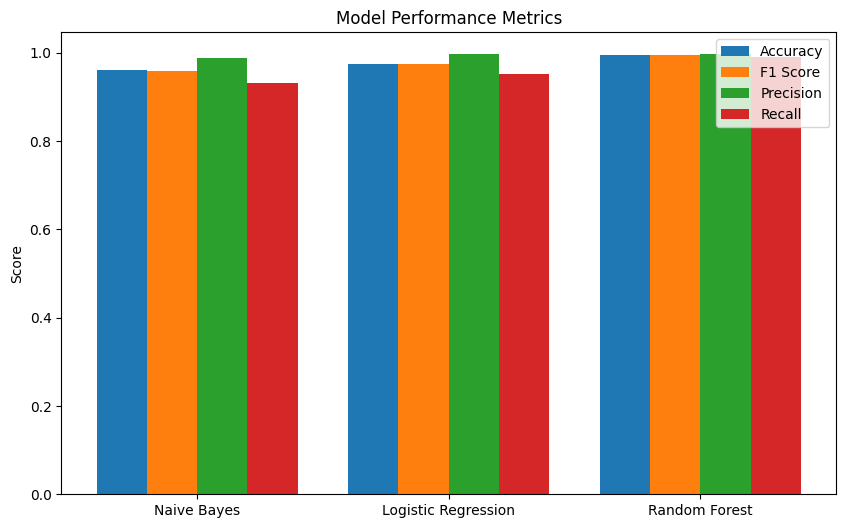

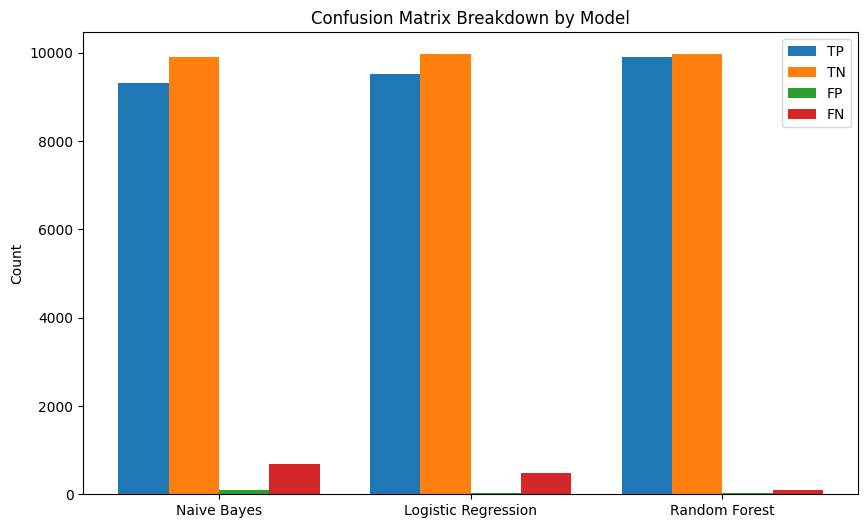

In [28]:
import matplotlib.pyplot as plt

# ===============================
# 📊 Plot Model Performance
# ===============================
metrics = ["Accuracy", "F1 Score", "Precision", "Recall"]

# Bar chart for main metrics
plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.bar([x + i*0.2 for x in range(len(results_df))],
            results_df[metric], width=0.2, label=metric)

plt.xticks([x + 0.3 for x in range(len(results_df))], results_df["Model"])
plt.ylabel("Score")
plt.title("Model Performance Metrics")
plt.legend()
plt.show()

# ===============================
# 📊 Plot Confusion Matrix Breakdown (TP, TN, FP, FN)
# ===============================
plt.figure(figsize=(10, 6))
confusion_parts = ["TP", "TN", "FP", "FN"]

for i, part in enumerate(confusion_parts):
    plt.bar([x + i*0.2 for x in range(len(results_df))],
            results_df[part], width=0.2, label=part)

plt.xticks([x + 0.3 for x in range(len(results_df))], results_df["Model"])
plt.ylabel("Count")
plt.title("Confusion Matrix Breakdown by Model")
plt.legend()
plt.show()


SAVING RANDOM FOREST

In [ ]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

# ===============================
# 🎯 Base Random Forest
# ===============================
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# ===============================
# 📏 Calibrated Wrapper
# ===============================
# isotonic = more flexible (needs more data)
# sigmoid = Platt scaling (good if less data)
cal_rf = CalibratedClassifierCV(rf, cv=5, method='isotonic')

# Train on the whole dataset
cal_rf.fit(X, y)

# ===============================
# 💾 Save calibrated model
# ===============================
calibrated_package = {
    "model": cal_rf,
    "features": features
}

output_path = r"D:\QRMODELTRAINING\backend\PKLMODELS\random_forest_qrusader_calibrated.pkl"
joblib.dump(calibrated_package, output_path)

print(f"✅ Calibrated Random Forest model saved to: {output_path}")


✅ Calibrated Random Forest model saved to: D:\QRMODELTRAINING\PKLMODELS\random_forest_qrusader_calibrated.pkl


MODEL TESTING FOR NEW URLS

In [ ]:

import joblib
import pandas as pd
import re, math
from collections import Counter
from urllib.parse import urlparse

# ===============================
# 1️⃣ Load trained model package
# ===============================
model_path = r"D:\QRMODELTRAINING\backend\PKLMODELS\random_forest_qrusader_calibrated.pkl"
rf_package = joblib.load(model_path)

rf_model = rf_package["model"]
features = rf_package["features"]

print("✅ Random Forest model loaded with features:", features)

# ===============================
# 2️⃣ Helper functions
# ===============================
SUSPICIOUS_KEYWORDS = {"login", "verify", "secure", "account", "update", 
                       "bank", "free", "bonus", "signin", "paypal"}

def shannon_entropy(s):
    if not s: return 0
    probs = [c/len(s) for c in Counter(s).values()]
    return -sum(p * math.log2(p) for p in probs)

def extract_features(url):
    parsed = urlparse(url)
    domain = parsed.netloc
    path = parsed.path

    url_length = len(url)
    has_ip = int(bool(re.search(r'(\d{1,3}\.){3}\d{1,3}', url)))
    subdomain_count = max(len(domain.split('.')) - 2, 0)
    https_token = int(url.startswith('https'))
    path_depth = len([p for p in path.split('/') if p])
    letters = sum(c.isalpha() for c in url)
    digits = sum(c.isdigit() for c in url)
    digit_letter_ratio = digits / letters if letters > 0 else 0
    special_chars = sum(not c.isalnum() for c in url)
    special_char_ratio = special_chars / len(url) if len(url) > 0 else 0
    repeated_char_count = sum(1 for i in range(1, len(url)) if url[i] == url[i-1])
    domain_entropy = shannon_entropy(domain)
    path_entropy = shannon_entropy(path)
    long_subdomain_length = max((len(p) for p in domain.split('.')[:-2]), default=0)
    url_has_suspicious_keywords = int(any(kw in url.lower() for kw in SUSPICIOUS_KEYWORDS))
    has_multiple_subdomains = int(subdomain_count > 1)

    query_param_count = url.count('&') + (1 if '?' in url else 0)
    vowel_count = sum(1 for c in url.lower() if c in 'aeiou')
    consonant_count = sum(1 for c in url.lower() if c.isalpha() and c not in 'aeiou')
    digit_special_ratio = digits / (special_chars + 1e-6)
    max_path_segment_length = max([len(seg) for seg in path.split('/')], default=0)

    return {
        'url_length': url_length,
        'subdomain_count': subdomain_count,
        'path_depth': path_depth,
        'digit_letter_ratio': digit_letter_ratio,
        'special_char_ratio': special_char_ratio,
        'repeated_char_count': repeated_char_count,
        'domain_entropy': domain_entropy,
        'path_entropy': path_entropy,
        'long_subdomain_length': long_subdomain_length,
        'query_param_count': query_param_count,
        'vowel_count': vowel_count,
        'consonant_count': consonant_count,
        'digit_special_ratio': digit_special_ratio,
        'max_path_segment_length': max_path_segment_length,
        'has_ip': has_ip,
        'https_token': https_token,
        'url_has_suspicious_keywords': url_has_suspicious_keywords,
        'has_multiple_subdomains': has_multiple_subdomains
    }

# ===============================
# 3️⃣ Test URLs
# ===============================
test_urls = [
    "https://www.wikipedia.org",
    "https://www.python.org/doc/",
    "https://www.nytimes.com/",
    "https://github.com/explore",
    "https://www.stackoverflow.com/questions/tagged/python",
    "https://www.facebook.com/watszuppketchup.24/",
    "https://www.microsoft.com/en-us",
    "https://www.apple.com/iphone/",
    "https://www.amazon.com/",
    "https://www.cnn.com/",
    "https://www.bbc.com/news",
    "https://scholar.google.com/",
    "https://www.linkedin.com/in/",
    "https://www.reddit.com/r/learnpython/",
    "https://www.khanacademy.org/",
    "https://about.twitter.com/en",
    "https://www.paypal.com/signin",
    "https://www.dropbox.com/",
    "https://store.steampowered.com/",
    "https://arxiv.org/"
]

# ===============================
# 4️⃣ Prediction + Thresholding
# ===============================
X_test = pd.DataFrame([extract_features(u) for u in test_urls])
X_test = X_test.reindex(columns=features, fill_value=0)

# Probabilities from calibrated model
probs = rf_model.predict_proba(X_test)  # shape (n, 2)

def risk_level(prob_malicious: float) -> str:
    if prob_malicious < 0.40:
        return "✅ Safe"
    elif prob_malicious < 0.70:
        return "⚠️ Medium Risk"
    else:
        return "🚨 High Risk"

# Collect results
results = []
for url, (prob_benign, prob_malicious) in zip(test_urls, probs):
    results.append({
        "URL": url,
        "Prob_Benign": round(float(prob_benign), 3),
        "Prob_Malicious": round(float(prob_malicious), 3),
        "Risk_Level": risk_level(prob_malicious)
    })

# Display as DataFrame
df_results = pd.DataFrame(results)
print("\n🔎 URL Risk Analysis:")
print(df_results.to_string(index=False))



✅ Random Forest model loaded with features: ['url_length', 'subdomain_count', 'path_depth', 'digit_letter_ratio', 'special_char_ratio', 'repeated_char_count', 'domain_entropy', 'path_entropy', 'long_subdomain_length', 'query_param_count', 'vowel_count', 'consonant_count', 'digit_special_ratio', 'max_path_segment_length', 'has_ip', 'https_token', 'url_has_suspicious_keywords', 'has_multiple_subdomains']

🔎 URL Risk Analysis:
                                                  URL  Prob_Benign  Prob_Malicious  Risk_Level
                            https://www.wikipedia.org        0.991           0.009      ✅ Safe
                          https://www.python.org/doc/        0.994           0.006      ✅ Safe
                             https://www.nytimes.com/        0.999           0.001      ✅ Safe
                           https://github.com/explore        0.000           1.000 🚨 High Risk
https://www.stackoverflow.com/questions/tagged/python        0.994           0.006      ✅ Safe
  